In [1]:
%matplotlib inline
import sys
sys.path.append("/Users/edwardlrichards/compAcoustics") 
sys.path.append("/Users/edwardlrichards/swellEx") 

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import swellEx_env
import loadCSDM as cm
from normalMode import Chinook
from beamformers import bartlet

In [2]:
# Experimental data
dataFile = '/Users/edwardlrichards/swellEx/data/J1312315.vla.21els.sio'
fs = 1500
tStart = 1000
snapLength = 2
snapStep = 1
sD = 54

In [3]:
frequencies = [49, 64, 79, 94, 112, 130, 148, 166, 201, 235, 283, 338, 388]

rSource = 6e3
zSource = 44


enviornment = swellEx_env.loadEnviornment(ctdNumber = 6)
sensorPosition = swellEx_env.loadArray()

# Match field boundries
zMax = enviornment.getProfile(0.).getZatInterface()[1]
rMax = 1e4  # m
numR = 200
numZ = 100

# Solver Parameters
decimation = 10
fB_width = 300

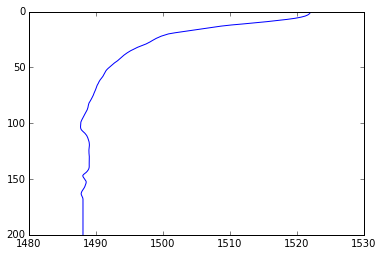

In [4]:
c = enviornment.getProfile(0.).getC_profile()
z = np.arange(c.size)
_ = plt.plot(c, z)
_ = plt.ylim(200, 0)
_ = plt.xlim(1480, 1530)

In [5]:
zPlot = np.r_[0:zMax:numZ * 1j]
rPlot = np.r_[10:rMax:numR * 1j]
R_nm, Z = np.meshgrid(rPlot, zPlot)

In [6]:
def _reshapeLookVectors(lookVectors):
    """Stack lookVectors into a (r * z) x s matrix
    Input:
    lookVectors is a list of model outputs, of length s, where s is the number of sensors
    Each element of the list is a r x z matrix, output from an acoustic model
    r is number of search ranges
    z is number of search depths
    
    Output:
    (r * z) x s matrix of all look vectors, suitable for batch beamforming
    """
    
    lookVectors = np.dstack(lookVectors)
    # normalize look vectors
    lookVectors = lookVectors / np.linalg.norm(lookVectors, axis = 2)[:,:,None]
    lookVectors = np.nan_to_num(lookVectors)

    # Stack into a m by n grid, where m is number of look position,
    # n is number of sensors
    shape_3d = lookVectors.shape
    lookVectors = np.reshape(lookVectors, (shape_3d[0] * shape_3d[1], shape_3d[2]))
    return lookVectors

In [7]:
def calculateField(enviornment, rPlot, zPlot, fB_width = 300, decimation = 10):
    """Create a function to calculate acoustic field by normal modes
    
    Input:
    enviornment is output of makeEnv function
    rPlot is an r element array of ranges of interest
    zPlot is an z element array of depths of interest
    fB_width is the false bottom width used in the normal mode eigen solver
    decimation is the minimum number of samples per mode zero crossing
    
    Output:
    acousticModel: acousticModel(frequency, sourceDepth) returns a r x z matrix of the pressure at ranges and depths of interest. Frequency is a number, while the input sd can be a number or an array.
    """
    
    def acousticModel(frequency, sourceDepth):
        nm_model = Chinook(frequency, enviornment)
        nm_model.calculateModes_eig(fB_width, decimation)
        
        try:
            # source depth is an iterable
            p_nm = [nm_model.calculatePressure(sd, zPlot, rPlot) for sd in sourceDepth]
            p_nm = pd.Series(p_nm, index = sourceDepth)
        except TypeError:
            # source depth is a single value
            p_nm = nm_model.calculatePressure(sourceDepth, zPlot, rPlot)
        return p_nm
    
    return acousticModel

In [8]:
def makeLookVectors(frequencies, sensorDepth, acousticModel):
    """Make look vectors used in matched field beamforming
    
    Runs an eigen solver normal mode code for replicas.
    
    Input: 
    frequencies of interest. Number or array
    sensorDepth
    zLook: array of look depths
    rlook: array of look ranges
    acousticModel(frequency, sd) returns a pressure field as an r x z matrix.
    r is the number of range guesses, z is the number of depth guesses
    
    Output:
    lookVectors as a (r * z) x s matrix, where r is rLook.size, z is zLook.size and s is sensorDepth.size
    If frequencies was an array, output will be a series, indexed by frequency
    """
    try:
        # frequencies is an iterable
        lookVectors = [_reshapeLookVectors(acousticModel(f, sensorDepth)) for f in frequencies]
        lookVectors = pd.Series(lookVectors, index = frequencies)
    except TypeError:
        # Single frequency
        lookVectors = acousticModel(frequencies, sensorDepth)
        lookVectors = _reshapeLookVectors(lookVectors)
    
    return lookVectors

In [9]:
def bart_DB(K, W):
    B_bart = bartlet(K, W)
    B_bart = np.reshape(B_bart, (numR, numZ))
    B_bart = 10 * np.log10(np.abs(B_bart) + np.spacing(1))
    B_bart = B_bart - np.max(B_bart)
    return B_bart

In [10]:
fOfInterest = frequencies[:6]
acousticModel = calculateField(enviornment, rPlot, zPlot, fB_width = 300, decimation = 10)
lookVectors = makeLookVectors(fOfInterest, sensorPosition, acousticModel)

dataIter = cm.SnapshotLoad(dataFile, fs, tStart, snapLength, snapStep,
                          channelNames = sensorPosition.index)
processingFunction = cm.NarrowBandPressure(fOfInterest)
kGen = cm.CSDM(dataIter, processingFunction)

In [11]:
np.real(np.array(lookVectors.iloc[0])).shape

(20000, 21)

In [12]:
# Synthetic data set
K = []
for f in fOfInterest:
    nm_model = Chinook(f, enviornment)
    nm_model.calculateModes_eig(fB_width, decimation)
    p = nm_model.calculatePressure(zSource, sensorPosition, rSource)
    K.append(np.outer(p, np.array(p).conj()))
K = pd.Series(K, index = fOfInterest)

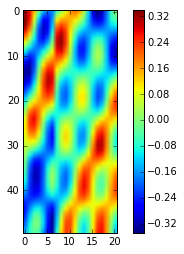

In [13]:
_ = plt.imshow(np.real(np.array(lookVectors.iloc[1]))[1250:1300,:])
_ = plt.colorbar()

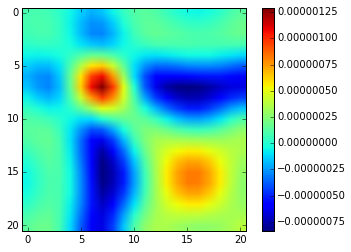

In [14]:
_ = plt.imshow(np.real(K.iloc[1]))
_ = plt.colorbar()

In [15]:
B_bart = [bart_DB(k, w) for k, w in zip(K, lookVectors)]
# B_bart = [bart_DB(k, w) for k, w in zip(K, W)]

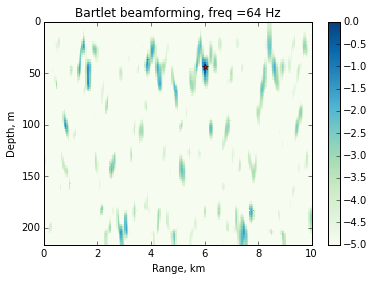

In [16]:
plotI = 1
_ = plt.pcolormesh(R_nm / 1e3, Z, np.array(B_bart[plotI]).T, cmap = plt.cm.GnBu)
_ = plt.clim(-5, 0)
_ = plt.colorbar()
_ = plt.xlim(0, rMax / 1e3)
_ = plt.ylim(zMax,0)
_ = plt.title('Bartlet beamforming, freq =' + str(fOfInterest[plotI]) + ' Hz')
_ = plt.plot(rSource / 1e3, zSource, 'r*')
_ = plt.ylabel('Depth, m')
_ = plt.xlabel('Range, km')

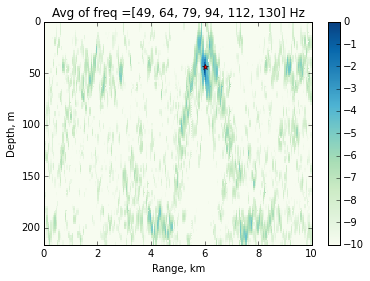

In [17]:
avgBart = np.sum(np.array(B_bart), axis = 0) / len(B_bart)
_ = plt.pcolormesh(R_nm / 1e3, Z, avgBart.T, cmap = plt.cm.GnBu)
_ = plt.clim(-10, 0)
_ = plt.colorbar()
_ = plt.xlim(0, rMax / 1e3)
_ = plt.ylim(zMax,0)
_ = plt.title('Avg of freq =' + str(fOfInterest) +' Hz')
_ = plt.plot(rSource / 1e3, zSource, 'r*')
_ = plt.ylabel('Depth, m')
_ = plt.xlabel('Range, km')